# 02-pinkify-dir-dev.ipynb

## Import packages

In [1]:
from pathlib import Path
import sys
# Third-party imports
import imageio as iio
import matplotlib.pyplot as plt
import napari
import numpy as np
from skimage import color, exposure, transform, util
# Custom module imports
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import helpers

In [2]:
%load_ext autoreload
%autoreload 2

## Setup NB and load pink image

In [3]:
viewer = napari.Viewer()

In [4]:
project_dir = Path.cwd().parent.resolve()
project_dir

WindowsPath('C:/Users/cgusb/projects/archipelago')

## Load image

In [5]:
def load_img(img_dir, img_n=0, img_suffix='.jpg'):
    img_paths = [path for path in Path(img_dir).glob(f'*{img_suffix}')]
    img_paths.sort()
    img = iio.imread(img_paths[img_n])
    return img

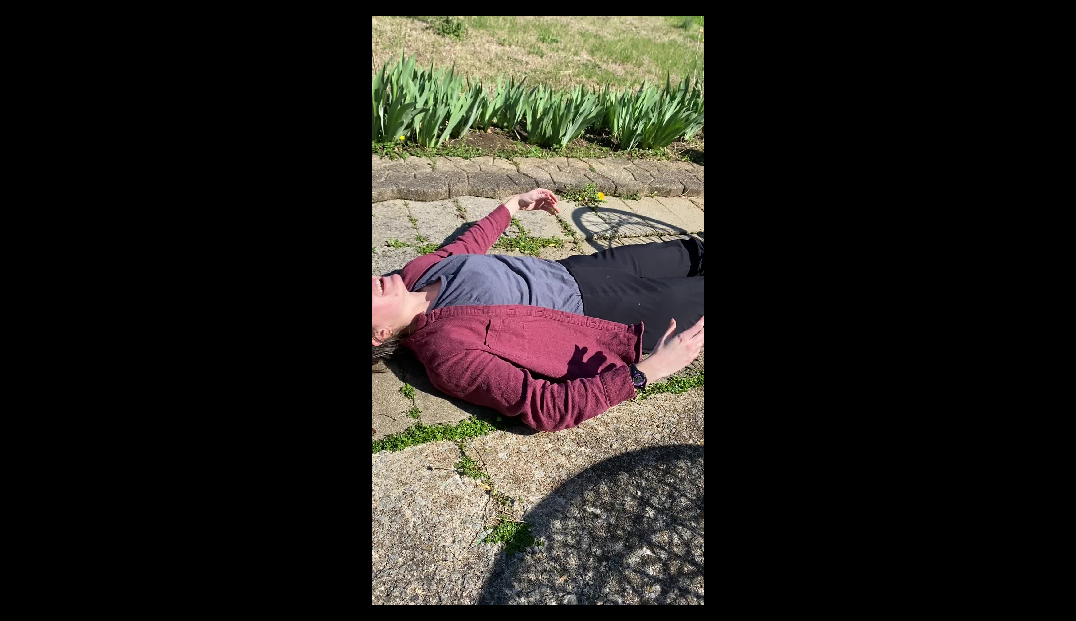

In [6]:
vid_frames_dir = Path(project_dir / 'videos/mc-laying/frames/')
img = load_img(vid_frames_dir, 0)
helpers.view(viewer, img)

## Pinkify image

pink_hsv[:, :, 1].min()=0.08333333333333337
pink_hsv[:, :, 1].max()=0.08333333333333337


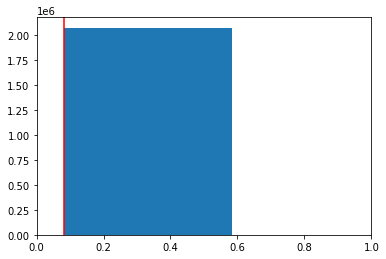

In [14]:
pink_hsv = helpers.pink_like(img, img_type='hsv')
print(f'{pink_hsv[:, :, 1].min()=}')
print(f'{pink_hsv[:, :, 1].max()=}')
pink_s_mean = pink_hsv[:, :, 1].mean()
fig, ax = helpers.plot_hist(pink_hsv, chan=1, cumul=True, vlines=pink_s_mean)
plt.show()

In [7]:
def pinkify(img, convert_rgb=False):
    pink_rgb = helpers.pink_like(img)
    pink_hsv = color.rgb2hsv(pink_rgb)
    img_hsv = color.rgb2hsv(img)
    pink_hsv[:, :, 1] = img_hsv[:, :, 1]
    if convert_rgb:
        pink_rgb = color.hsv2rgb(pink_hsv)
        return util.img_as_ubyte(pink_rgb)
    return pink_hsv

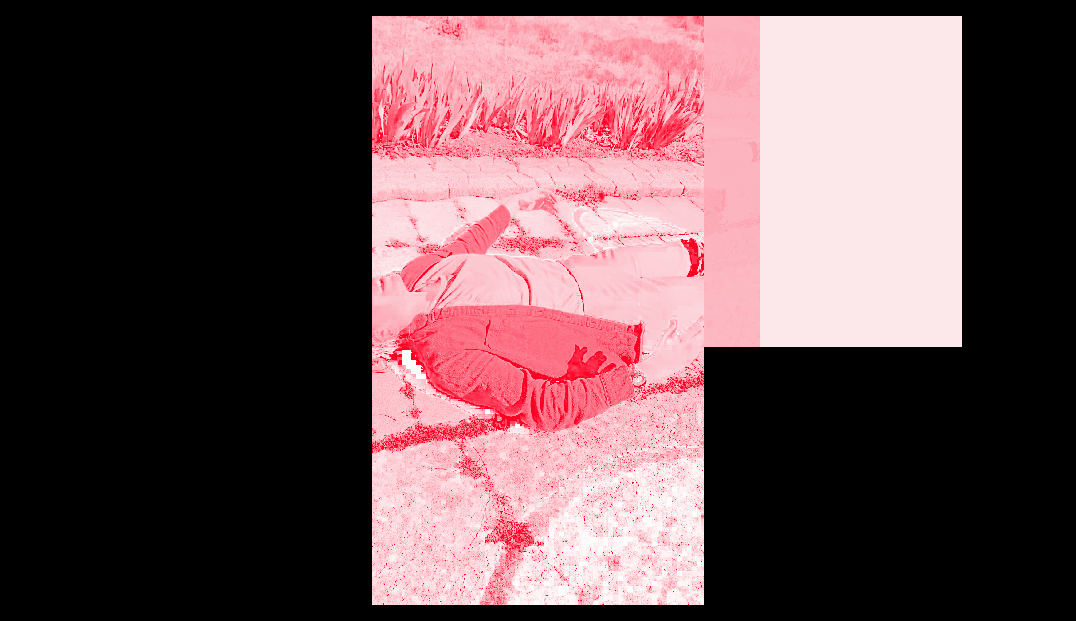

In [16]:
pink_img_hsv = pinkify(img)
pink_img_rgb = color.hsv2rgb(pink_img_hsv)
helpers.view(viewer, pink_img_rgb)

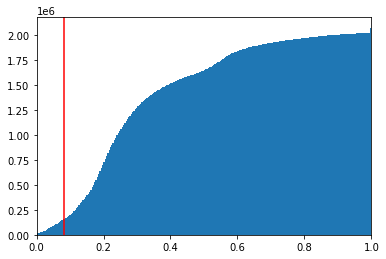

In [17]:
fig, ax = helpers.plot_hist(pink_img_hsv, chan=1, cumul=True, vlines=pink_s_mean)
plt.show()

## Rescale intensity of saturation

Rather than span [0, 1], saturation intensity will be rescaled to a range within some value of the saturation of the all pink image

## Pinkify all images in directory

0.3142175126122945


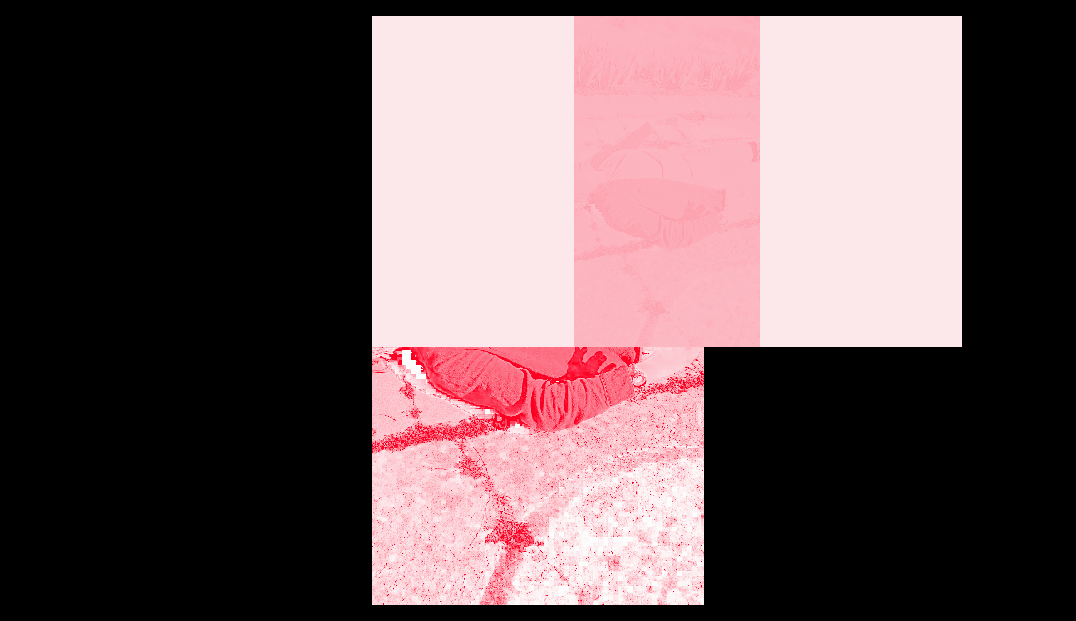

In [10]:
def pinkify_dir(
    img_dir, col_offset='center', canvas_size=(1080, 1920, 3), sat_spread=0.05, 
    img_suffix='.jpg'
):
    # Load image
    img = load_img(img_dir)
    img_resized = helpers.resize_by_nrows(img, canvas_size[0])
    nrows, ncols, nchans = img_resized.shape
    # Pinkify image
    pink_hsv = pinkify(img_resized, convert_rgb=False)
    # Rescale saturation to +/- sat spread around mean
    pink_s_mean = pink_hsv[:, :, 1].mean()
    print(pink_s_mean)
    pink_hsv[:, :, 1] = exposure.rescale_intensity(
        pink_hsv[:, :, 1], 
        out_range=(pink_s_mean - sat_spread, pink_s_mean + sat_spread)
    )
    # Make pink canvas
    canvas = helpers.pink(canvas_size)
    canvas_hsv = color.rgb2hsv(canvas)
    # Add pink image to part of pink canvas
    if col_offset == 'center':
        col_offset = canvas_size[1] // 2 - (ncols // 2) 
    canvas_hsv[:, col_offset:col_offset + ncols, :] = pink_hsv
    canvas_rgb = color.hsv2rgb(canvas_hsv)
    return canvas_rgb
    # return np.array(pink_imgs)
vid_frames_dir = Path(project_dir / 'videos/mc-laying/frames/')
vid_frames_dir.exists()
pink_imgs = pinkify_dir(vid_frames_dir)
viewer.add_image(pink_imgs)
napari.utils.nbscreenshot(viewer, canvas_only=True)